# 03 — Backtesting the trend-following strategy

Purpose:
- Apply the lagged trend signal to daily returns.
- Construct cumulative performance for the strategy and for buy-and-hold.
- Quantify risk using volatility, drawdowns, and Sharpe-like metrics.
- Keep assumptions minimal and transparent (no leverage, no transaction costs).


In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
DATA_PATH = Path("../data/processed/SPY_with_signal.csv")

df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
df = df.sort_index()

df.head()

,Adj Close,Close,High,Low,Open,Volume,ret_simple,ret_log,vol_20d_ann,ma_200,signal_naive,signal
Date,,,,,,,,,,,,
1993-02-01,24.413826,44.25000,44.25000,43.96875,43.96875,480500,0.007113,0.007088,NaN,NaN,0,0.0
1993-02-02,24.465551,44.34375,44.37500,44.12500,44.21875,201300,0.002119,0.002116,NaN,NaN,0,0.0
1993-02-03,24.724171,44.81250,44.84375,44.37500,44.40625,529400,0.010571,0.010515,NaN,NaN,0,0.0
1993-02-04,24.827604,45.00000,45.09375,44.46875,44.96875,531500,0.004184,0.004175,NaN,NaN,0,0.0
1993-02-05,24.810381,44.96875,45.06250,44.71875,44.96875,492100,-0.000694,-0.000694,NaN,NaN,0,0.0


In [5]:
required = {"Adj Close", "ret_simple", "signal"}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

print("Rows:", len(df))
print("Date range:", df.index.min().date(), "->", df.index.max().date())

df[["ret_simple", "signal"]].isna().sum()

Rows: 8309
Date range: 1993-02-01 -> 2026-02-03


ret_simple    0
signal        0
dtype: int64

In [6]:
# Strategy return:
# - if signal = 1 → earn market return
# - if signal = 0 → earn 0 (cash)
df["ret_strategy"] = df["signal"] * df["ret_simple"]

df[["ret_simple", "signal", "ret_strategy"]].head(10)

,ret_simple,signal,ret_strategy
Date,,,
1993-02-01,0.007113,0.0,0.0
1993-02-02,0.002119,0.0,0.0
1993-02-03,0.010571,0.0,0.0
1993-02-04,0.004184,0.0,0.0
1993-02-05,-0.000694,0.0,-0.0
1993-02-08,0.000000,0.0,0.0
1993-02-09,-0.006950,0.0,-0.0
1993-02-10,0.001400,0.0,0.0
1993-02-11,0.004892,0.0,0.0


In [7]:
df["cum_buy_hold"] = (1 + df["ret_simple"]).cumprod()
df["cum_strategy"] = (1 + df["ret_strategy"]).cumprod()

df[["cum_buy_hold", "cum_strategy"]].tail()

,cum_buy_hold,cum_strategy
Date,,
2026-01-28,28.687282,14.457333
2026-01-29,28.630354,14.428644
2026-01-30,28.544963,14.385610
2026-02-02,28.686869,14.457125
2026-02-03,28.676969,14.452136


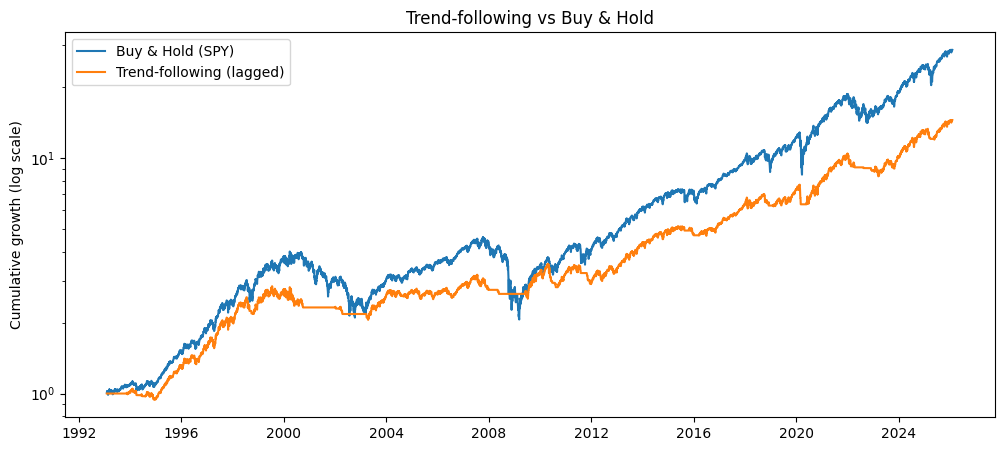

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["cum_buy_hold"], label="Buy & Hold (SPY)")
plt.plot(df.index, df["cum_strategy"], label="Trend-following (lagged)")
plt.yscale("log")
plt.ylabel("Cumulative growth (log scale)")
plt.title("Trend-following vs Buy & Hold")
plt.legend()
plt.show()

In [9]:
def compute_drawdown(cum: pd.Series) -> pd.Series:
    peak = cum.cummax()
    drawdown = (cum / peak) - 1
    return drawdown

df["dd_buy_hold"] = compute_drawdown(df["cum_buy_hold"])
df["dd_strategy"] = compute_drawdown(df["cum_strategy"])

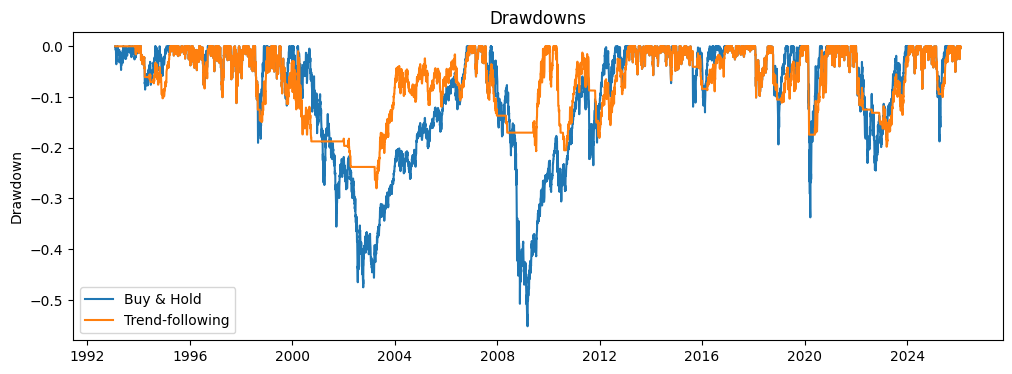

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["dd_buy_hold"], label="Buy & Hold")
plt.plot(df.index, df["dd_strategy"], label="Trend-following")
plt.ylabel("Drawdown")
plt.title("Drawdowns")
plt.legend()
plt.show()

In [11]:
def perf_stats(r: pd.Series, name: str) -> pd.Series:
    r = r.dropna()
    ann_return = (1 + r).prod() ** (252 / len(r)) - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan
    max_dd = compute_drawdown((1 + r).cumprod()).min()
    
    return pd.Series({
        "annual_return": ann_return,
        "annual_vol": ann_vol,
        "sharpe_like": sharpe,
        "max_drawdown": max_dd,
        "n_days": len(r)
    }, name=name)

stats = pd.concat([
    perf_stats(df["ret_simple"], "Buy & Hold"),
    perf_stats(df["ret_strategy"], "Trend-following"),
], axis=1).T

stats

,annual_return,annual_vol,sharpe_like,max_drawdown,n_days
Buy & Hold,0.107146,0.186149,0.575591,-0.551895,8309.0
Trend-following,0.084374,0.119801,0.704282,-0.279960,8309.0


In [12]:
invested_frac = df["signal"].mean()
print(f"Fraction of days invested: {invested_frac:.2%}")

Fraction of days invested: 75.20%


In [13]:
# Count signal changes (entries + exits)
df["signal_change"] = df["signal"].diff().abs()
n_trades = df["signal_change"].sum()

years = (df.index[-1] - df.index[0]).days / 365.25
print(f"Approx trades per year: {n_trades / years:.2f}")

Approx trades per year: 6.45


In [14]:
OUT_PATH = Path("../data/processed/SPY_backtest_results.csv")
df.to_csv(OUT_PATH, index=True)
print(f"Saved backtest results to {OUT_PATH}")

Saved backtest results to ../data/processed/SPY_backtest_results.csv
